# Training a simple Face Mask Detection Classifier using the FastAi library


Masks play an important role in protecting the health of individuals
against respiratory diseases. Masks have become a necessity during the current pandemic situation since they are one of the few precautions available in the absence of immunization. 

This project aims to create a classier that predicts whether a person in an image is:
- (properly) wearing a mask,
- wearing a mask improperly, or 
- not wearing a mask at all. 

We will use the [fastai](https://github.com/fastai/fastai) deep learning library to create this classifier. This library provides the experimental tools to quickly and easily genereate state-of-the-art results in many deep learning domains.

In [87]:
# in order for fast-ai package to not produce errors/warnings, let's install the required PyTorch version
!pip install "torch==1.4" "torchvision==0.5.0"

First let's setup the necessary packages and configurations.

In [41]:
# ensures that any edits to libraries are reloaded automatically 
%reload_ext autoreload
%autoreload 2

# show charts and/or images in the notebook itself.
%matplotlib inline

# import all computer-vision related packages from fast-ai
from fastai.vision import *

# import the error-rate metic
from fastai.metrics import error_rate

# in order to access the necessary data - we have to mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## The Data

To train the 'mask detection classifier', we are going to use the [Mask Dataset (Make ML)](https://makeml.app/datasets/mask). 

This dataset has images that fall into three classes:
- Images of people **with mask**,
- Images of people **without mask**,
- Images of people **wearing masks incorrectly**.

The labels of these images are stored as folder names in this particular dataset. Therefore, we have to extract the folder names when we import the data in order to train our classifier. We can use the fastai library's `ImageDataBunch.from_folder()` function to execute this step.

In [17]:
# path to the parent folder and train dataset folder
path = '/content/drive/My Drive/my_projects'
image_path = '/datasets/mask_data/train/'

np.random.seed(16) # to guarantee that the same validation set
bs = 32 # batch size to sample

data = ImageDataBunch.from_folder(path + image_path 
                                  , valid_pct=0.25
                                  , size=200
                                  , bs=bs
                                  , seed =  16
                                  , ds_tfms=get_transforms()
                                  ).normalize(imagenet_stats)

Before we move onto train the classifier, let's take a look at the data to understand what the problem is and how does the data look like.



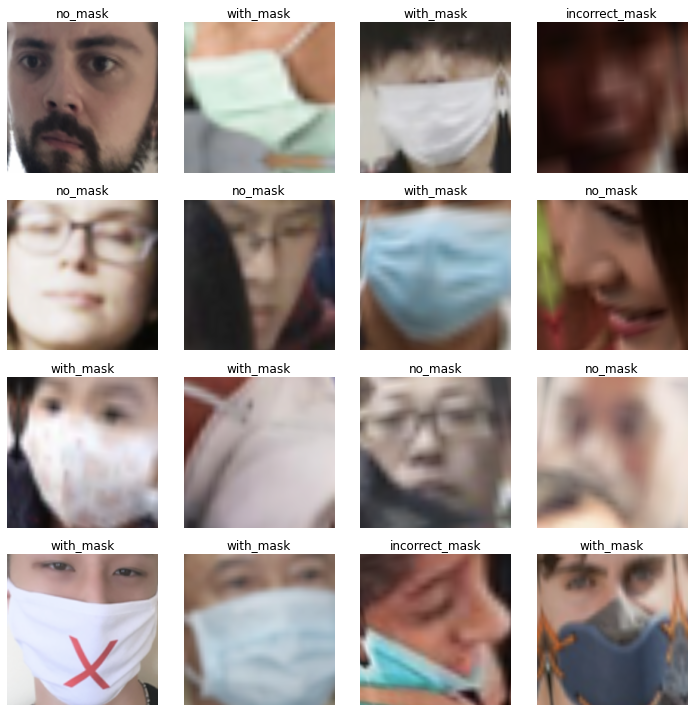

In [38]:
data.show_batch(rows=4, figsize=(10,10))

In [19]:
print(data.classes)
len(data.classes),data.c

['incorrect_mask', 'no_mask', 'with_mask']


(3, 3)

We can see that the images are grouped under three categories: `with_mask`, `no_mask` and `incorrect_mask`. The corresponding images contain face-images of people wearing masks as per the assigned category.

## Training a classifier using transfer-learning 

Instead of training a classifier from scratch, we use the technique of [transfer learning](https://en.wikipedia.org/wiki/Transfer_learning) to create our model. Transfer learning technique focuses on applying the knowledge gained when solving one problem to solve a different but a related problem. 

### Using the weights of `ResNet34`


We train our first classifier using the [`ResNet34`](https://pytorch.org/hub/pytorch_vision_resnet/) model architecture. 

Let's train our classifier with these pre-trained weights for 4 epochs.

In [26]:
learnRes34 = cnn_learner(data, models.resnet34, metrics=error_rate)

learnRes34.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.962703,0.550357,0.153680,00:18
1,0.643265,0.429303,0.108225,00:18
2,0.464482,0.343920,0.101732,00:18
3,0.360837,0.293868,0.088745,00:18


In [21]:
# save the trained classifer (model) weights
learnRes34.save(path + '/models/mask_detect_weights_resnet_34_stage_1')

#### Results

Looking at the training results, we see that after the 4th epoch, the error-rate of our classifier was ~9%. That means it can predict the correct category ~91% of the time.

Let's observe the predictions of the model to understand which categories that the classifier got most confused with another. This helps us to verify the performance of the model. 



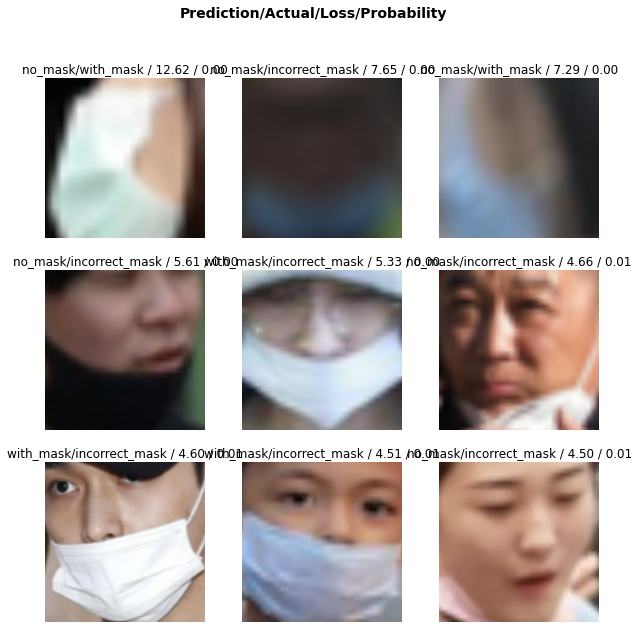

In [27]:
interpRes34 = ClassificationInterpretation.from_learner(learnRes34)

interpRes34.plot_top_losses(9, figsize=(10,10))

The mistakes of the classifier were mostly among `incorrect_mask` vs others. This is reasonable because the `incorrect_mask` category lies between the other two classes. This step indicates that our classifier works as intended.

The below confusion matrix also confirms that the model makes the most mistakes when identifying the `incorrect mask` category.


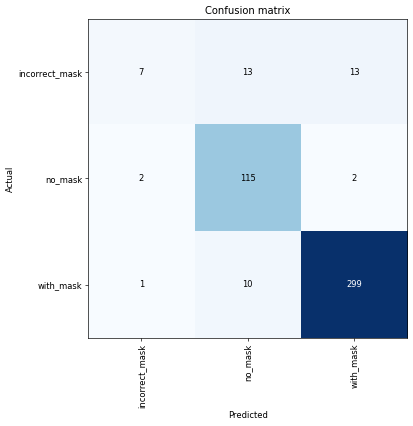

In [28]:
interpRes34.plot_confusion_matrix(figsize=(7,7), dpi=60)

Below `most_confused()` function also supports the above conclusion.

In [29]:
interpRes34.most_confused(min_val=10)

[('incorrect_mask', 'no_mask', 13),
 ('incorrect_mask', 'with_mask', 13),
 ('with_mask', 'no_mask', 10)]

### Using the weights of `ResNet50`


Let's use the more complex `ResNet50` architecture which has more layers than `ResNet34` to train a classifier and check if that can produce better predictions.

Since `ResNet50` has a high number of layers, it can extract more features. Therefore, let's use slightly larger images in our dataset.

In [37]:
data_b = ImageDataBunch.from_folder(path + image_path 
                                  , valid_pct = 0.25
                                  , size = 300
                                  , bs = bs
                                  , seed =  16
                                  , ds_tfms = get_transforms()
                                  ).normalize(imagenet_stats)


learnRes50 = cnn_learner(data_b, models.resnet50, metrics=error_rate)

learnRes50.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.939615,0.561532,0.147186,00:47
1,0.622656,0.301379,0.086580,00:47
2,0.435782,0.261422,0.077922,00:47
3,0.316495,0.240176,0.080087,00:47


In [218]:
# save the trained classifer (model) weights
learnRes50.save(path + '/models/mask_detect_weights_resnet_50_stage_1')

#### Results


Above results show us that the error-rate of the new classifier drops ~7%  after 3 epochs and increases to 8% in the 4th epoch of training. This shows signs of overfitting.

Overall, the classifier that we trained using `ResNet50` seems perform better than the classifier trained using `ResNet34` model.

We can perform the same analysis as above to identify the classes our classifier was most confused with.


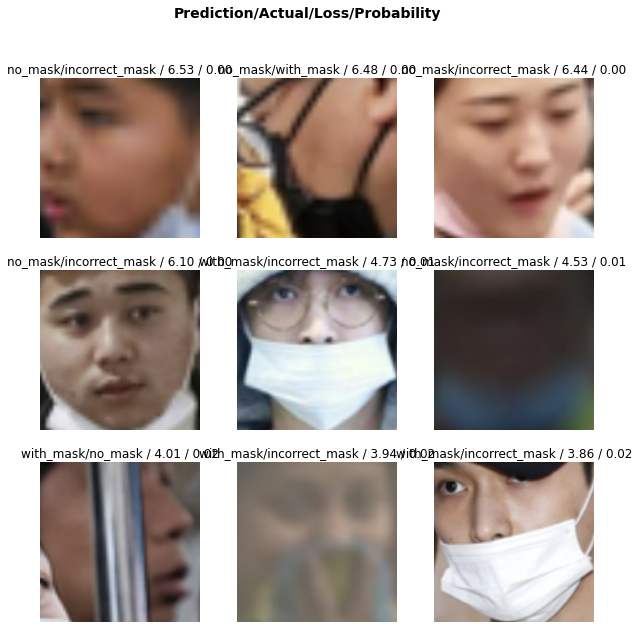

In [39]:
interpRes50 = ClassificationInterpretation.from_learner(learnRes50)

interpRes50.plot_top_losses(9, figsize=(10,10))

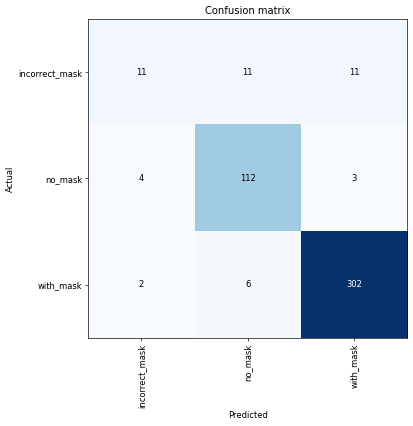

In [40]:
interpRes50.plot_confusion_matrix(figsize=(7,7), dpi=60)

The new classifier has a slighly higher accuracy in identifying the `incorrect_mask` class than the previous classifier, whereas the `no_mask` class is identified with less accuracy.

## Unfreezing the pre-trained networks for fine-tuning

Instead of using the pre-trained weights as they are (i.e., keeping them *freezed*), now we are going to train all parameters of `ResNet34` and `ResNet50` models using our training data. We hope that by doing this, we would be able to train classifiers that have higher accuracy.


#### Unfreezing and fine-tuning the classifiers based on `ResNet34` and `ResNet50` 

In [69]:
learnRes34_ii = cnn_learner(data, models.resnet34, metrics=error_rate)
learnRes34_ii.load(path + '/models/mask_detect_weights_resnet_34_stage_1'); 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


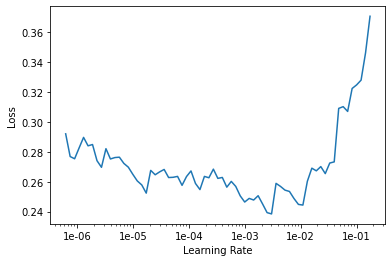

In [70]:
# run learning-rate finder to manually pick learning rates for NN
learnRes34_ii.lr_find()
learnRes34_ii.recorder.plot()

In [48]:
# unfreeze the weights
learnRes34_ii.unfreeze()

# pick learning rates using above graph
learnRes34_ii.fit_one_cycle(4, max_lr=slice(1/8000,1/400))

epoch,train_loss,valid_loss,error_rate,time
0,0.313930,1.136596,0.112554,00:19
1,0.307432,0.572424,0.088745,00:19
2,0.221283,0.118523,0.041126,00:19
3,0.165354,0.127502,0.036797,00:20


In [49]:
# save the new model weights
learnRes34_ii.save(path + '/models/mask_detect_weights_resnet_34_stage_2')

Comparing above results with the previous classifier that we traind using `ResNet34` model weights, we can see that the new error rate is ~4% lower! The new classifier would predict the correct class ~96% of the time!!

Let's apply the same process on the classifier based on `ResNet50` model and compare the results.

In [78]:
learnRes50_ii = cnn_learner(data_b, models.resnet50, metrics=error_rate)
learnRes50_ii.load(path + '/models/mask_detect_weights_resnet_50_stage_1'); # load previously trained model weights

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


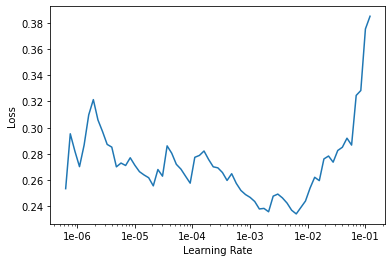

In [74]:
# run learning-rate finder to manually pick learning rates for NN
learnRes50_ii.lr_find()
learnRes50_ii.recorder.plot()

In [76]:
# unfreeze the weights
learnRes50_ii.unfreeze()

# pick learning rates using above graph
learnRes50_ii.fit_one_cycle(4, max_lr=slice(1/60000,1/600))

epoch,train_loss,valid_loss,error_rate,time
0,0.177162,0.655838,0.125541,01:01
1,0.288874,0.210695,0.075758,01:01
2,0.232796,0.158358,0.047619,01:01
3,0.170269,0.127457,0.034632,01:01


In [87]:
# save the new model weights
learnRes50_ii.save(path + '/models/mask_detect_weights_resnet_50_stage_2')

The fine-tuned `learnRes50_ii` that we created using `ResNet50` network records an error rate ~3.4%. This is even slightly less than the error rate of the tuned `ResNet34` based model.

#### Results

As the final step, let's have a look at the confusion matrices of the fine-tuned models.

In [88]:
interpRes34_ii = ClassificationInterpretation.from_learner(learnRes34_ii)
interpRes50_ii = ClassificationInterpretation.from_learner(learnRes50_ii)

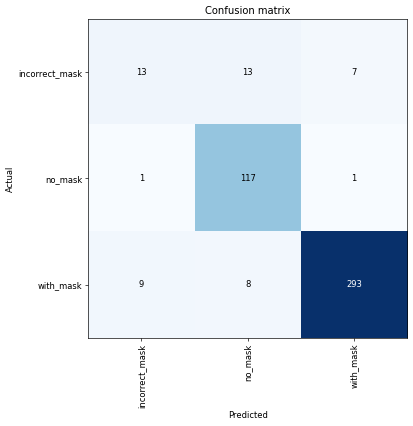

In [89]:
interpRes34_ii.plot_confusion_matrix(figsize=(7,7), dpi=60)

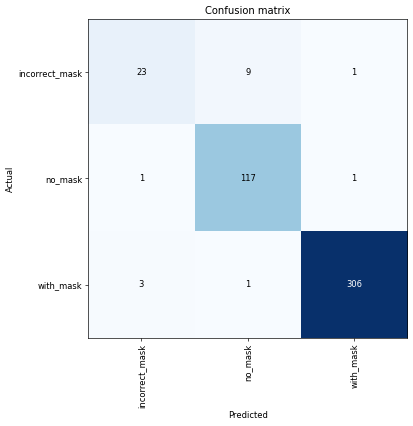

In [90]:
interpRes50_ii.plot_confusion_matrix(figsize=(7,7), dpi=60)

As we can observe in the above results, the fine-tuned `ResNet50` based classifier accurately predicts all three classes better than `ResNet34` based classifier. Therefore, we can conclude that the `interpRes50_ii` classifier is more suitable to draw inferences about the proper use of face masks in image inputs.